In [1]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import tensorflow_hub as hub

from urllib.request import urlopen
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import os
import csv
import os
import csv
import numpy as np
import gensim.downloader as api

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

2023-04-24 18:13:49.204329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 18:13:49.815490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [3]:
glove_embeddings = loadGloveModel("./glove.6B.100d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [4]:
# Setting up the paths
train_data_path = "./Data/datasets/flowers/"
train_images_path = "./Data/datasets/flowers/jpg"
train_captions_path = "./Data/datasets/flowers/text_c10"

The following packages will be used to implement a basic GAN system in Python/Keras.

In [5]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [6]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 200

# Configuration
DATA_PATH = train_images_path
MODEL_PATH = "./Data/datasets/flowers/model"
EPOCHS = 300
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


## Data Pre-Processing 

Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [7]:
# Image set has 8,188 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

training_binary_path = os.path.join("./Data/datasets/flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
        image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
        channel = np.asarray(image).shape[2]
        if channel == 3:
            training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
        pass
    if len(training_data) == 100:
        training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
        training_data = training_data.astype(np.float32)
        #Normalizing the input
        training_data = training_data / 127.5 - 1.

        print("Saving training image " + str(100000 + filename) + ".npy")
        np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
        elapsed = time.time()-start
        print (f'Image preprocess time: {hms_string(elapsed)}')
        training_data = []
print("Complete")

Loading training images...


/tmp/ipykernel_2652965/2845223836.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)


Saving training image 100099.npy
Image preprocess time: 0:00:00.64
Saving training image 100199.npy
Image preprocess time: 0:00:01.18
Saving training image 100299.npy
Image preprocess time: 0:00:01.72
Saving training image 100399.npy
Image preprocess time: 0:00:02.23
Saving training image 100499.npy
Image preprocess time: 0:00:02.73
Saving training image 100599.npy
Image preprocess time: 0:00:03.23
Saving training image 100699.npy
Image preprocess time: 0:00:03.73
Saving training image 100799.npy
Image preprocess time: 0:00:04.26
Saving training image 100899.npy
Image preprocess time: 0:00:04.76
Saving training image 100999.npy
Image preprocess time: 0:00:05.31
Saving training image 101099.npy
Image preprocess time: 0:00:05.86
Saving training image 101199.npy
Image preprocess time: 0:00:06.37
Saving training image 101299.npy
Image preprocess time: 0:00:06.87
Saving training image 101399.npy
Image preprocess time: 0:00:07.41
Saving training image 101499.npy
Image preprocess time: 0:00:0

Next we will load and preprocess the captions. This can take awhile. Google CoLab took around an hour to process. Because of this we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [8]:

# Define the path to the root directory containing the folders
root_directory = './Data/datasets/flowers/text_c10/'

# Create a list to store the text data
text_data = []

# Loop through each folder in the root directory
for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Loop through each text file in the directory
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            # Check if the path is a file and if it has a .txt extension
            if os.path.isfile(file_path) and file_name.endswith('.txt'):
                # Open the file and read its contents
                with open(file_path, 'r') as file:
                    file_contents = file.read()
                # Append the file name and contents to the text_data list
                text_data.append([folder_name, file_name, file_contents])

# Write the contents of the text_data list to a CSV file
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Folder', 'File Name', 'Text'])
    for row in text_data:
        writer.writerow(row)



In [9]:
# Load pre-trained GloVe embeddings
glove_model = api.load('glove-twitter-200')

# Define the path to the captions.csv file
# captions_path = "./captions.csv"
captions_path = "./output.csv"

# Read the contents of the captions.csv file into a list of dictionaries
with open(captions_path, 'r') as file:
    reader = csv.DictReader(file)
    captions = [row['Text'] for row in reader]

# Generate embeddings for each caption
caption_embeddings = np.zeros((len(captions), 200), dtype=np.float32)
for i, caption in enumerate(captions):
    # Split the caption into individual words
    words = caption.split()
    # Calculate the average embedding for the words in the caption
    word_embeddings = [glove_model[word.lower()] for word in words if word.lower() in glove_model]
    if len(word_embeddings) > 0:
        caption_embeddings[i] = np.mean(word_embeddings, axis=0)

# Save the caption embeddings to a file
np.save('./Data/datasets/flowers/text_c10/caption_embeddings.npy', caption_embeddings)


In [10]:
# # saving the caption embeddings numpy
# embedding_binary_path = os.path.join('D:/Text-to-Image-Using-GAN-master/Data/datasets/flowers/images/embedding_npy',
#         f'embedding_data.npy')
# print("Saving captions embeddings binary...")
# np.save(embedding_binary_path,caption_embeddings)

In [11]:
# # Creating a dataframe to store the captions
# df_captions = pd.DataFrame([])
# df_captions['captions'] = captions[:len(final_images)]
df_captions = pd.read_csv("./output.csv")

In [12]:
df_captions.head()

,Folder,File Name,Text
0,class_00100,image_07896.txt,this is a large flower with red and yellow pet...
1,class_00100,image_07894.txt,the petals on this plant are thin and are red ...
2,class_00100,image_07900.txt,the petals of this flower are red and yellow w...
3,class_00100,image_07931.txt,a group of red flowers with yellow tipped peta...
4,class_00100,image_07926.txt,this flower has a yellow and brown center surr...


## Loading and combining numpys

In [13]:
caption_embeddings = np.load('./Data/datasets/flowers/text_c10/caption_embeddings.npy')
print(caption_embeddings.shape)

(8189, 200)


In [14]:
#caption_embeddings = caption_embeddings[::5]

In [15]:
caption_embeddings.shape

(8189, 200)

In [16]:
image_binary_path = "./Data/datasets/flowers/images/npy64/"
images = os.listdir(image_binary_path)

In [17]:
images[-1]

'training_data_64_64_101199.npy'

In [18]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
    print(i)
    try:
        final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
    except:
        pass

training_data_64_64_103799.npy
training_data_64_64_102499.npy
training_data_64_64_103699.npy
training_data_64_64_107399.npy
training_data_64_64_104599.npy
training_data_64_64_107199.npy
training_data_64_64_105399.npy
training_data_64_64_102999.npy
training_data_64_64_100999.npy
training_data_64_64_100699.npy
training_data_64_64_107299.npy
training_data_64_64_104299.npy
training_data_64_64_100799.npy
training_data_64_64_106399.npy
training_data_64_64_103599.npy
training_data_64_64_103399.npy
training_data_64_64_100099.npy
training_data_64_64_104999.npy
training_data_64_64_108099.npy
training_data_64_64_104199.npy
training_data_64_64_100299.npy
training_data_64_64_101799.npy
training_data_64_64_105599.npy
training_data_64_64_106899.npy
training_data_64_64_102299.npy
training_data_64_64_100599.npy
training_data_64_64_105499.npy
training_data_64_64_101599.npy
training_data_64_64_101099.npy
training_data_64_64_103999.npy
training_data_64_64_105999.npy
training_data_64_64_105799.npy
training

In [19]:
final_images.shape

(8100, 64, 64, 3)

In [20]:
captions = list(df_captions.Text)

In [21]:
#df_captions = df_captions.rename(columns={'File Name': 'id', 'Text': 'captions'})

In [22]:
len(captions)

8189

Saved images separately for testing

In [23]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [24]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [25]:
caption_embeddings.shape

(8100, 200)

Shuffling the data

In [26]:
p = np.random.permutation(len(final_images))

In [27]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [28]:
final_images_shuffled.shape

(8100, 64, 64, 3)

In [29]:
final_embeddings_shuffled.shape

(8100, 200)

In [30]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-04-24 18:16:28.189687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


## Data Modeling

Defining the Generator and Discriminator

In [31]:
def build_generator_func(seed_size, embedding_size, channels):
    input_seed = Input(shape=seed_size)
    input_embed = Input(shape = embedding_size)
    d0 = Dense(128)(input_embed)
    leaky0 = LeakyReLU(alpha=0.2)(d0)

    merge = Concatenate()([input_seed, leaky0])

    d1 = Dense(4*4*256,activation="relu")(merge)
    reshape = Reshape((4,4,256))(d1)

    upSamp1 = UpSampling2D()(reshape)
    conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
    batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
    leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

    upSamp2 = UpSampling2D()(leaky1)
    conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    upSamp3 = UpSampling2D()(leaky2)
    conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
    conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
    outputActi = Activation("tanh")(outputConv)

    model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
    return model

def build_discriminator_func(image_shape, embedding_size):
    input_shape = Input(shape=image_shape)
    input_embed = Input(shape=embedding_size)

    conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
    leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

    drop2 = Dropout(0.25)(leaky1)
    conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
    # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
    batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
    leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

    drop3 = Dropout(0.25)(leaky2)
    conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
    batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
    leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

    drop4 = Dropout(0.25)(leaky3)
    conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
    batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
    leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

    dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
    leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
    reshape_embed = Reshape((4,4,8))(leaky_embed)
    merge_embed = Concatenate()([leaky4, reshape_embed])

    drop5 = Dropout(0.25)(merge_embed)
    conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
    batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
    leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

    drop6 = Dropout(0.25)(leaky5)
    flatten = Flatten()(drop6)
    output = Dense(1,activation="sigmoid")(flatten)

    model = Model(inputs=[input_shape,input_embed], outputs=output)
    return model

Function to save image samples generated

In [32]:
def save_images(cnt,noise,embeds):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict((noise,embeds))

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
            image_count += 1
    
    output_path = "./Data/datasets/output"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

2023-04-24 18:16:30.018827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-24 18:16:30.161899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 18:16:30.787037: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor([[0.50667137]], shape=(1, 1), dtype=float32)


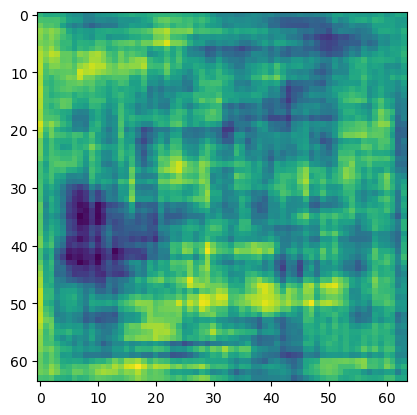

In [33]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,200)), training=False)
plt.imshow(generated_image[0, :, :, 0])

# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)

decision = discriminator((generated_image,caption_embeddings[5].reshape(1,200)))
print(decision)

In [34]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [35]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=2e-4,
#     decay_steps=100,
#     decay_rate=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator((seed,captions), training=True)
        real_image_real_text = discriminator((images,captions), training=True)
        real_image_fake_text = discriminator((images,fake_captions), training=True)
        fake_image_real_text = discriminator((generated_images,captions), training=True)

        gen_loss = generator_loss(fake_image_real_text)
        disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
        # print(gen_loss)
        # print(disc_loss)

        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
        return gen_loss,disc_loss

In [37]:
# import matplotlib.pyplot as plt

# # initialize FPR list
# fpr_list = []

# # function that executes training process
# def train(train_dataset, epochs):
#     fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,SEED_SIZE))
#     fixed_embed = save_images_embeddings

#     start = time.time()

#     for epoch in range(epochs):
#         print("epoch start...")
#         epoch_start = time.time()

#         gen_loss_list = []
#         disc_loss_list = []
#         gen_losses = []
#         disc_losses = []

#         for batch in train_dataset[:-1]:
#             train_batch = batch['images']
#             caption_batch = batch['embeddings']

#             fake_caption_batch = np.copy(caption_batch)
#             np.random.shuffle(fake_caption_batch)

#             t = train_step(train_batch,caption_batch,fake_caption_batch)
#             gen_loss_list.append(t[0])
#             disc_loss_list.append(t[1])

#             # get discriminator predictions for real/fake images and real/fake captions
#             real_image_real_text = discriminator((train_batch, caption_batch), training=False)
#             real_image_fake_text = discriminator((train_batch, fake_caption_batch), training=False)
#             fake_image_real_text = discriminator((generator((seed, caption_batch), training=False), caption_batch), training=False)

#             # calculate false positive rate (FPR) for real/fake captions
#             fpr_real = tf.keras.metrics.FalsePositives()
#             fpr_real.update_state(tf.ones_like(real_image_real_text), real_image_real_text)
#             fpr_real.update_state(tf.zeros_like(real_image_fake_text), real_image_fake_text)
#             fpr_real_result = fpr_real.result().numpy()

#             fpr_fake = tf.keras.metrics.FalsePositives()
#             fpr_fake.update_state(tf.ones_like(real_image_real_text), fake_image_real_text)
#             fpr_fake.update_state(tf.zeros_like(real_image_fake_text), real_image_fake_text)
#             fpr_fake_result = fpr_fake.result().numpy()

#             # append FPR to list
#             fpr_list.append((fpr_real_result + fpr_fake_result) / 2)

#         # calculate average generator/discriminator loss for epoch
#         g_loss = sum(gen_loss_list) / len(gen_loss_list)
#         d_loss = sum(disc_loss_list) / len(disc_loss_list)

#         epoch_elapsed = time.time()-epoch_start
#         print(f'Epoch {epoch+1}, gen loss={g_loss}, disc loss={d_loss}, {hms_string(epoch_elapsed)}')

#         # plot FPR vs. training step
#         plt.plot(fpr_list)
#         plt.title("False Positive Rate (FPR)")
#         plt.xlabel("Training Step")
#         plt.ylabel("FPR")
#         plt.show()

#         # save generator/discriminator models and preview images
#         save_images(epoch,fixed_seed,fixed_embed)
#         generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
#         discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
#         print("model saved")

#         elapsed = time.time()-start


In [38]:
# Function that executes trianing process
def train(train_dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,SEED_SIZE))
    fixed_embed = save_images_embeddings

    start = time.time()

    for epoch in range(epochs):
        print("epoch start...")
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []
        gen_losses = []
        disc_losses = []

        for batch in train_dataset[:-1]:
          # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
          # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
            train_batch = batch['images']
            caption_batch = batch['embeddings']

            fake_caption_batch = np.copy(caption_batch)
            np.random.shuffle(fake_caption_batch)

            t = train_step(train_batch,caption_batch,fake_caption_batch)
            # print(t)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            # if image_batch%50 == 0:
            #   print(image_batch)
            # print("here")
        print("now")
        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
        save_images(epoch,fixed_seed,fixed_embed)
        generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
        discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
        print("model saved")

        elapsed = time.time()-start



In [39]:
train(list(train_dataset.as_numpy_iterator()), 2500)

2023-04-24 18:16:31.568334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [8100,200]
	 [[{{node Placeholder/_0}}]]
2023-04-24 18:16:31.568546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [8100,64,64,3]
	 [[{{node Placeholder/_1}}]]


epoch start...


2023-04-24 18:16:34.010887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-24 18:16:35.118587: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1b640c1f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 18:16:35.118626: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-04-24 18:16:35.122011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 18:16:35.177503: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-24 18:16:35.236023: I ./tensorflow/compiler/jit/device_compile

now
Epoch 1, gen loss=0.7084743976593018,disc loss=1.5723927021026611, 0:00:12.27
1/1 [==============================] - 0s 376ms/step
model saved
epoch start...
now
Epoch 2, gen loss=0.7700285911560059,disc loss=1.4732749462127686, 0:00:04.53
1/1 [==============================] - 0s 76ms/step
model saved
epoch start...
now
Epoch 3, gen loss=0.7609009742736816,disc loss=1.4388355016708374, 0:00:04.42
1/1 [==============================] - 0s 15ms/step
model saved
epoch start...
now
Epoch 4, gen loss=0.736353874206543,disc loss=1.4371693134307861, 0:00:04.37
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 5, gen loss=0.7368239760398865,disc loss=1.4316972494125366, 0:00:04.40
1/1 [==============================] - 0s 16ms/step
model saved
epoch start...
now
Epoch 6, gen loss=0.7328377366065979,disc loss=1.4210788011550903, 0:00:04.40
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 7, gen loss=0.7242469787

## Results

In [40]:
generator.load_weights("./Data/datasets/flowers/model/text_to_image_generator_cub_character.h5")
discriminator.load_weights("./Data/datasets/flowers/model/text_to_image_disc_cub_character.h5")

In [41]:
save_images_embeddings.shape

(28, 200)

In [42]:
# Printing the captions
save_images_captions

['this is a large flower with red and yellow petals and a brown stem.\nthis flower has petals that are red with yellow tips and many purple stamen.\nthis is a flower with petals that are red toward the center and yellow around the edges.\nthis flower has petals that are red with yellow tips\nthis flower is pink and yellow in color, with petals that are yellow near the tips.\nthe stamen are dark red and cover a round center of the flower, surrounded by petals that are dark pink closest to the center and bright yellow furthest from the center of the flower.\nthis flower has many petals which are yellow on the edges and red near the middle.\nthis flower has red petals with yellow tips and purple stamen\nthis flower is pink and yellow in color, and has petals that are multi colored.\nthere are many dark red filaments surrounded by mostly red petals that turn to yellow at their tip.\n',
 'the petals on this plant are thin and are red with yellow tips\nthis flower has petals that are red wit

In [43]:
glove_model = api.load('glove-twitter-200')

In [44]:
def test_image(text,num):
    test_embeddings = np.zeros((1,200),dtype=np.float32)

    x = text.lower()
    x = x.replace(" ","")
    count = 0
    for t in x:
        try:
            test_embeddings[0] += glove_model[t]
            count += 1
        except:
            #print(t)
            pass
    print(test_embeddings)
    if count != 0:
        test_embeddings[0] /= count
    else:
        return
    test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
    noise = tf.random.normal([28, 100])
    save_images(num,noise,test_embeddings)

In [45]:
# def test_image(text,num):
#     test_embeddings = np.zeros((1,200),dtype=np.float32)

#     x = text.lower()
#     x = x.replace(" ","")
#     count = 0
#     for t in x:
#         try:
#             test_embeddings[0] += glove_embeddings[t]
#             count += 1
            
#         except:
#             print(t)
#             pass
#     print(count)
#     print(test_embeddings)
#     test_embeddings[0] /= count
#     test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
#     noise = tf.random.normal([28, 100])
#     save_images(num,noise,test_embeddings)

In [46]:
import IPython

[[ 8.8488274e+00 -6.3596711e+00  7.2783966e+00 -4.8506737e+00
  -2.8250167e+00 -7.1752608e-01 -2.9842371e+01 -5.5355630e+00
  -5.1024184e+00  1.5407039e+01 -6.9949632e+00 -1.1839816e+01
  -6.1694674e+00  4.8820624e+00 -7.1881633e+00 -6.1490531e+00
  -1.2922376e+01 -2.8915164e+00 -2.1194096e+01  1.6911091e+01
  -3.1744752e+00 -9.2550917e+00  2.4651951e+01  1.3993286e+01
   1.0590823e+01 -6.1763893e+01 -8.2646284e+00 -8.6736679e+00
   2.3534412e+01  1.3863489e+01 -1.4661982e+01 -9.3478432e+00
  -9.4071846e+00  5.6499273e-01  2.0107777e+01 -3.5452217e-01
  -7.8760881e+00 -6.5186172e+00 -2.4814938e+01  8.9871750e+00
  -4.9516762e+01  8.5098705e+00  1.7526638e+01 -4.2491198e-01
  -5.9351044e+00  8.2808876e-01  1.9504803e-01 -1.3530692e+01
   6.0162277e+00 -1.3190752e+01  1.0965534e+00  7.3055387e-01
  -1.0252500e+00  9.2277517e+00  3.5739169e+00  3.5809753e+00
   9.2840302e-01 -5.9725924e+00  2.7216303e+00 -9.6437597e+00
  -1.0331582e+01  8.2303888e-01  1.1920154e-02 -2.2911775e+00
  -4.426

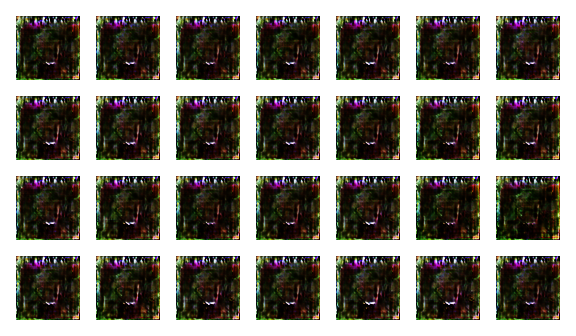

In [47]:
test_image("This flower is yellow in color with oval shaped petals", 1)
IPython.display.Image('./Data/datasets/output/train-1.png')

[[ 8.22277164e+00 -6.38372040e+00  1.05694065e+01 -1.35795224e+00
   8.46803963e-01  1.25016570e+00 -2.74883785e+01 -3.34806013e+00
  -6.40464830e+00  1.51644478e+01 -8.99650669e+00 -1.11330528e+01
  -6.83381844e+00  5.02891254e+00 -7.98462200e+00 -4.16463804e+00
  -1.49672270e+01 -4.62983847e+00 -2.64811401e+01  1.34910641e+01
  -5.22825432e+00 -1.01957712e+01  2.37989216e+01  1.26178827e+01
   1.36180658e+01 -5.83941994e+01 -1.12539072e+01 -1.09971218e+01
   2.49041138e+01  1.77721233e+01 -1.37809753e+01 -1.18160286e+01
  -8.96471310e+00  3.23135543e+00  1.73620777e+01 -2.82384396e+00
  -4.64361572e+00 -7.87279844e+00 -2.67733040e+01  8.80933380e+00
  -5.47006874e+01  9.50803471e+00  1.49716301e+01 -8.21754217e-01
  -1.90164495e+00 -2.18626595e+00 -1.85829893e-01 -1.21487751e+01
   6.27737856e+00 -1.12587910e+01  3.00489366e-01 -3.93683672e+00
   7.64945209e-01  9.67702770e+00  4.35121632e+00  2.59701180e+00
  -8.75631928e-01 -3.71301961e+00  4.31132364e+00 -8.89399433e+00
  -1.20718

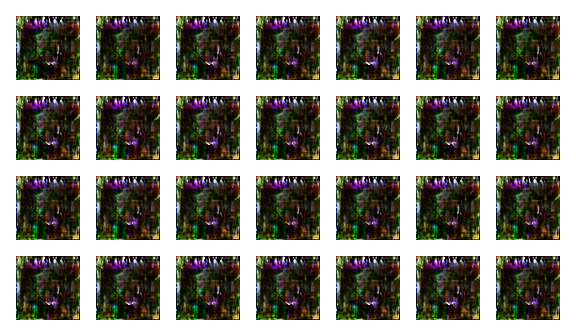

In [48]:
test_image("A large flower with pink and white petals and a brown stem", 2)
IPython.display.Image('./Data/datasets/output/train-2.png')

[[ 1.04959641e+01 -4.64171267e+00  8.21185303e+00 -4.82385540e+00
  -3.04528093e+00 -9.14190263e-02 -2.64085865e+01 -4.08776474e+00
  -4.29268789e+00  1.25486708e+01 -7.10189390e+00 -1.24668226e+01
  -6.87767744e+00  3.57367897e+00 -5.99686956e+00 -5.11689568e+00
  -1.21643915e+01 -2.94512177e+00 -2.10747337e+01  1.52723379e+01
  -5.10185909e+00 -9.22487736e+00  2.25141525e+01  1.29416752e+01
   8.71245384e+00 -5.37130966e+01 -8.08386612e+00 -7.74600983e+00
   2.31721115e+01  1.35371552e+01 -1.40855713e+01 -8.09836960e+00
  -9.20292759e+00  4.01129037e-01  1.65569592e+01 -9.92816925e-01
  -7.96731186e+00 -4.86502743e+00 -2.41296825e+01  8.63566971e+00
  -4.74766922e+01  9.14613533e+00  1.51319704e+01 -5.60699999e-01
  -4.54457474e+00 -1.20840967e-01  3.32778156e-01 -1.19229708e+01
   5.73105812e+00 -1.14599609e+01  7.13771462e-01  1.65142804e-01
  -1.40153360e+00  9.37357235e+00  2.23548889e+00  2.39437103e+00
   6.12736702e-01 -3.19526243e+00  1.07087123e+00 -9.40530682e+00
  -1.03631

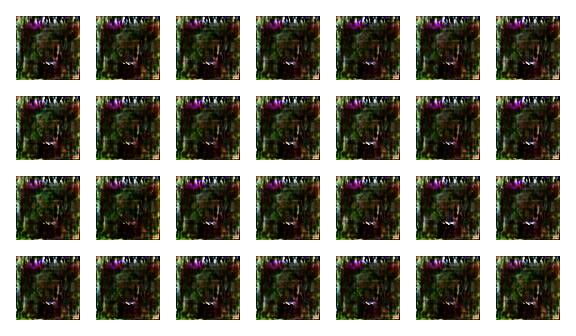

In [49]:
test_image("this flower is pink in color with oval shaped petals", 3)
IPython.display.Image('./Data/datasets/output/train-3.png')

[[ 8.89940739e+00 -7.59502888e+00  1.10652828e+01 -2.95459926e-01
   6.61693931e-01  2.46863842e+00 -2.53633823e+01 -8.75025749e-01
  -4.18233585e+00  1.67108097e+01 -5.55936909e+00 -1.09384499e+01
  -4.01896715e+00  5.99615335e+00 -7.89282179e+00 -3.87766314e+00
  -1.02627163e+01 -1.62286985e+00 -1.50158348e+01  1.46233110e+01
  -7.30301285e+00 -8.65466976e+00  2.19320889e+01  8.22451878e+00
   1.14337816e+01 -5.58297424e+01 -1.01301498e+01 -1.12838888e+01
   1.84409218e+01  1.46681643e+01 -1.04672041e+01 -7.77377939e+00
  -5.78995609e+00  5.95537615e+00  1.51722336e+01 -2.08767509e+00
  -5.76337427e-02 -8.81445694e+00 -2.56769886e+01  6.85517406e+00
  -4.67383499e+01  7.56003952e+00  1.39733505e+01 -5.43793023e-01
  -4.13417435e+00 -2.21230078e+00  9.55310047e-01 -1.23280277e+01
   2.50003457e+00 -1.26442814e+01  2.54137421e+00 -3.56556106e+00
   1.66709113e+00  1.00231361e+01  4.82016611e+00  2.33956766e+00
  -2.00061536e+00 -4.22182369e+00  5.34970617e+00 -1.01971674e+01
  -1.32851

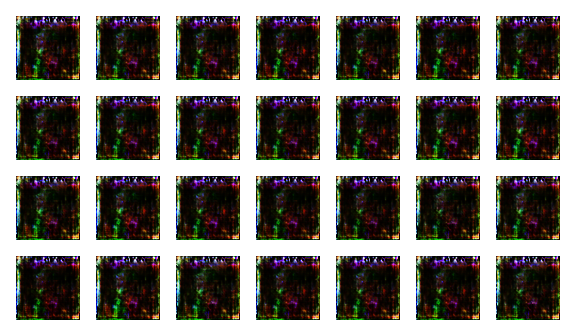

In [50]:
test_image("Image of a white lily surrounded by green leaves", 4)
IPython.display.Image('./Data/datasets/output/train-4.png')

Code Reference:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb

Paper Reference:
https://arxiv.org/pdf/1605.05396.pdf